# ESRGAN (`wonbeomjang` implementation)

## Setup

In [1]:
! git clone https://github.com/wonbeomjang/ESRGAN-pytorch.git

Cloning into 'ESRGAN-pytorch'...
remote: Enumerating objects: 416, done.
remote: Total 416 (delta 0), reused 0 (delta 0), pack-reused 416
Receiving objects: 100% (416/416), 164.64 MiB | 35.58 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [2]:
from google.colab import drive
import os, sys, shutil as sh
from pathlib import Path
import cv2, PIL, albumentations as A
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm

In [3]:
sys.path.append('/content/ESRGAN-pytorch')

In [4]:
drive.mount('/content/drive')
dir_mydrive = Path('/content/drive/My Drive')
dir_esrgan = Path('/content/ESRGAN-pytorch')

Mounted at /content/drive


In [5]:
def _cp(src, dst):
    import shutil
    assert src.is_file()
    shutil.copy(src, dst)

Path.cp = _cp
Path.ls = lambda x: list(x.iterdir())

## Useful functions

In [6]:
def get_same_view(img_hr, img_lr, b0_hr=None, b1_hr=None):
    '''
    Grab the same corresponding area from the high and low
    resolution images.

    `img_hr`: np.array
        High resolution image.
    `img_lr`: np.array
        Low resolution image.
    `b0_hr`: tuple
        Lower and upper index to subsection dimension 0 
        of high resolution image.
    `b1_hr`: tuple
        Lower and upper index to subsection dimension 1 
        of high resolution image.
    '''
    if b0_hr is None: 
        b0_hr = (0, img_hr.shape[0])
    if b1_hr is None: 
        b1_hr = (0, img_hr.shape[1])
    for b, l in zip((b0_hr, b1_hr), img_hr.shape[:2]):
        assert 0 <= b[0] < b[1] <= l
    assert img_hr.shape[0]//img_lr.shape[0] == img_hr.shape[1]//img_lr.shape[1]
    scale = img_hr.shape[0]//img_lr.shape[0]
    b0_lr = tuple(l//scale for l in b0_hr)
    b1_lr = tuple(l//scale for l in b1_hr)
    img_hr_ = img_hr[slice(*b0_hr),slice(*b1_hr)]
    img_lr_ = img_lr[slice(*b0_lr),slice(*b1_lr)]
    return img_hr_, img_lr_

In [7]:
def scale_image(img, scale=1, resample=PIL.Image.BICUBIC):
    new_size = tuple(int(scale * l) for l in img.size)
    return img.resize(size=new_size, resample=resample)

## Test pre-trained model

Test the pre-trained ESRGAN on some images.  Examples of images that are good for this purpose are the Singapore tiles.  It's hard to make out the details of roofs from these.

In [8]:
dir_sg = (dir_mydrive/'Official Folder for Engie project'/
          'Data'/'Satellite Imagery'/'Main Island'/'JPEG_tiles_Main')

Just grab 5 tiles for testing.

In [9]:
fns = dir_sg.ls()[510:510+5]
fns

FileNotFoundError: ignored

A directory is created to hold these images, which will be the input images to the model.  Another directory is also created to hold the output images that the model will generate.

In [ ]:
dir_in = Path('/content/input_tiles'); dir_in.mkdir(exist_ok=True)
dir_out = Path('/content/output_tiles'); dir_out.mkdir(exist_ok=True)

In [ ]:
for n in fns: n.cp(dir_in/n.name)

Then, simply execute the `test.py` script, specifying the input and the output directory paths.

In [ ]:
%%time

%cd ESRGAN-pytorch
! python test.py --lr_dir {str(dir_in)} --sr_dir {str(dir_out)}
%cd ..

/content/ESRGAN-pytorch
save main_5200_2800.jpeg
save main_5200_7200.jpeg
save main_5200_6800.jpeg
save main_5200_5600.jpeg
save main_5200_6400.jpeg
/content
CPU times: user 182 ms, sys: 45.3 ms, total: 227 ms
Wall time: 57.5 s


The model has generated 5 images in the output directory.

In [ ]:
dir_out.ls()

[PosixPath('/content/output_tiles/main_5200_2800.jpeg'),
 PosixPath('/content/output_tiles/main_5200_7200.jpeg'),
 PosixPath('/content/output_tiles/main_5200_6800.jpeg'),
 PosixPath('/content/output_tiles/main_5200_5600.jpeg'),
 PosixPath('/content/output_tiles/main_5200_6400.jpeg')]

Let's look at some input-output pair.

In [ ]:
idx = 2

fn_in = dir_in.ls()[idx]
fn_out = dir_out/fn_in.name

Because this model has a *scale factor* of 4, the output image's sides are 4 times longer than the input image's.  

In [ ]:
PIL.Image.open(fn_in).size, PIL.Image.open(fn_out).size

((512, 512), (2048, 2048))

Over the same screen area, plotting the input and output images side-by-side, it's seen that the model has changed colour.  But it's hard to say if it's revealed more details of the roof. 

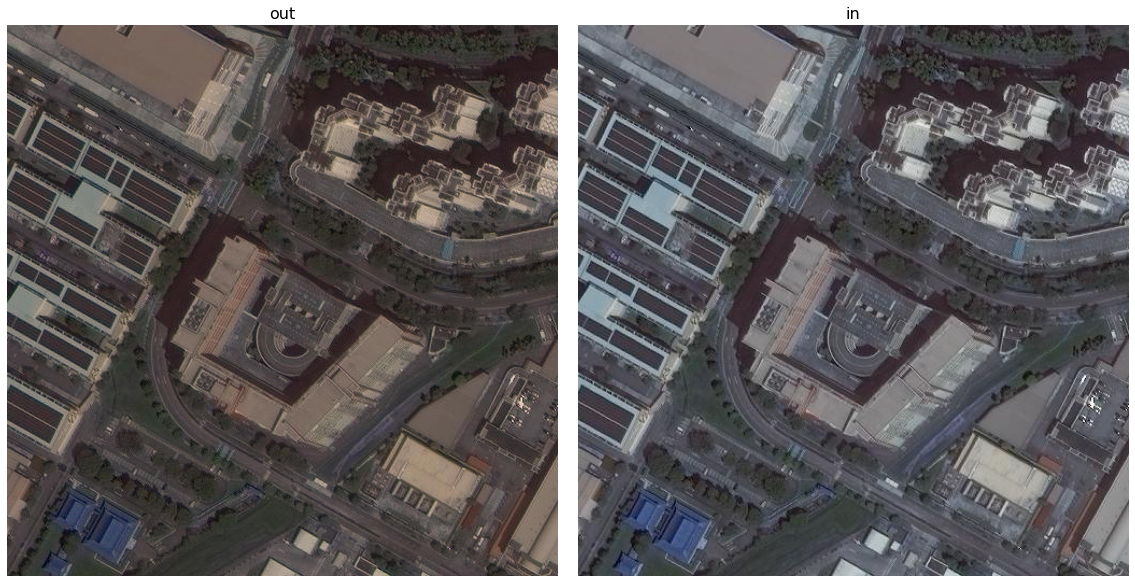

In [ ]:
img_in = np.array(PIL.Image.open(fn_in))
img_out = np.array(PIL.Image.open(fn_out))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs = axs.flatten()
for ax, label, img in zip(axs, ('out', 'in'), (img_out, img_in)):
    ax.imshow(img); ax.set_title(label, fontsize=16); ax.axis('off')

plt.tight_layout()

Zooming in on a small area of the image though, it's seen that the output image is slightly less pixelated.

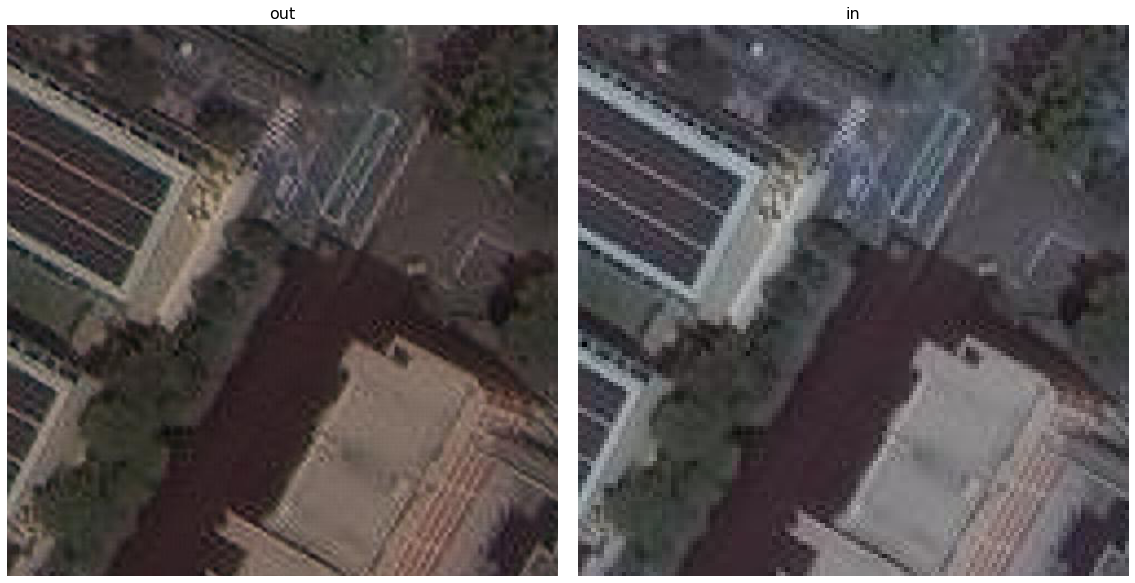

In [ ]:
img_in = np.array(PIL.Image.open(fn_in))
img_out = np.array(PIL.Image.open(fn_out))

img_out_, img_in_ = get_same_view(img_out, img_in, b0_hr=(500, 1000), b1_hr=(500, 1000))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs = axs.flatten()
for ax, label, img in zip(axs, ('out', 'in'), (img_out_, img_in_)):
    ax.imshow(img); ax.set_title(label, fontsize=16); ax.axis('off')

plt.tight_layout()

This was using the pre-trained model.  The question now is, if it's trained further on the Spacenet dataset, will it improve the output image (the one on the left) further?

## Prepare some training samples

So let's get some Spacenet images to train the model.

In [ ]:
dir_vegas = (dir_mydrive/'Official Folder for Engie project'/
             'task_6_image-resolution'/'Spacenet Datasets'/'vegas_jpeg')

For efficiency, let's grab just 20 Spacenet images.

In [ ]:
fns = [n for n in dir_vegas.ls() if str(n).endswith('.jpeg')][:20]
fns[:3]

[PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/Spacenet Datasets/vegas_jpeg/990.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/Spacenet Datasets/vegas_jpeg/250.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/Spacenet Datasets/vegas_jpeg/5396.jpeg')]

We take these images as our high-resolution images.  

To use the provided training script, a directory containing high-resolution images and another containing the low-resolution images are required.  We create these and copy the Spacenet images to the high-resolution directory.  (The low-resolution directory is empty at this point.)



In [ ]:
dir_hr = Path('/content/hr'); dir_hr.mkdir(exist_ok=True)
dir_lr = Path('/content/lr'); dir_lr.mkdir(exist_ok=True)

In [ ]:
for n in fns:
    n.cp(dir_hr/f'{n.stem}.png')

Low-resolution here means smaller in size, so we take each high-resolution image, scale it down (by a factor of 4 here), then save the resulting low-resolution image to the low-resolution directory.

In [ ]:
for n in dir_hr.ls():
    img_hr = PIL.Image.open(n)
    img_lr = scale_image(img_hr, scale=.25)
    img_lr.save(dir_lr/n.name)

The training script also requires these directories to be at the specific path `ESRGAN-pytorch/datasets`.

In [ ]:
dir_hr_ = dir_esrgan/'datasets'/'hr'
dir_lr_ = dir_esrgan/'datasets'/'lr'

for d in (dir_hr_, dir_lr_):
    if d.exists(): sh.rmtree(d)

dir_hr.replace(dir_hr_)
dir_lr.replace(dir_lr_)

dir_hr = dir_hr_
dir_lr = dir_lr_

To create more training samples, chop the images up into smaller ones.  The high-resolution ones into $128\times 128$ images; the low-resolution ones into $32\times 32$ images.  Note that the scale factor of $4 = 128 / 32$ is retained.

In [ ]:
from datasets.preparation.make_patches import crop_image

In [ ]:
%%time
crop_image(dir_hr, 128, 100)
crop_image(dir_lr, 32, 25)

[*] [0/20] Make patch /content/ESRGAN-pytorch/datasets/hr/5466.png
[*] [0/20] Make patch /content/ESRGAN-pytorch/datasets/lr/5466.png
CPU times: user 653 ms, sys: 74.4 ms, total: 728 ms
Wall time: 735 ms


Instead of having just 20 train samples, there are now 500.

In [ ]:
len(dir_hr.ls()), len(dir_lr.ls())

(500, 500)

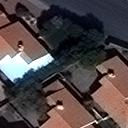

In [ ]:
idx = 34

PIL.Image.open(dir_hr.ls()[idx])

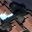

In [ ]:
PIL.Image.open(dir_lr.ls()[idx])

The model will be trained to take the bottom image into the top image.

## Train the ESRGAN

Now execute the training script to train the model.

In [ ]:
%cd ESRGAN-pytorch/
! python main.py --is_perceptual_oriented True --num_epoch=10
%cd ..

/content/ESRGAN-pytorch
ESRGAN start
[*] Load model from checkpoints
[!] No checkpoint in epoch -1
[Epoch 0/10] [Batch 0/32] [D loss 0.6901] [G loss 0.2556] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.2556]
[Epoch 1/10] [Batch 0/32] [D loss 0.0002] [G loss 0.0772] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0772]
[Epoch 2/10] [Batch 0/32] [D loss 0.0000] [G loss 0.0710] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0710]
[Epoch 3/10] [Batch 0/32] [D loss 0.0001] [G loss 0.0605] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0605]
[Epoch 4/10] [Batch 0/32] [D loss 0.0000] [G loss 0.0549] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0549]
[Epoch 5/10] [Batch 0/32] [D loss 0.0000] [G loss 0.0532] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0532]
[Epoch 6/10] [Batch 0/32] [D loss 0.0007] [G loss 0.0472] [adversarial loss 0.0000][perceptual loss 0.0000][content loss 0.0472

Some intermediate results output during training:

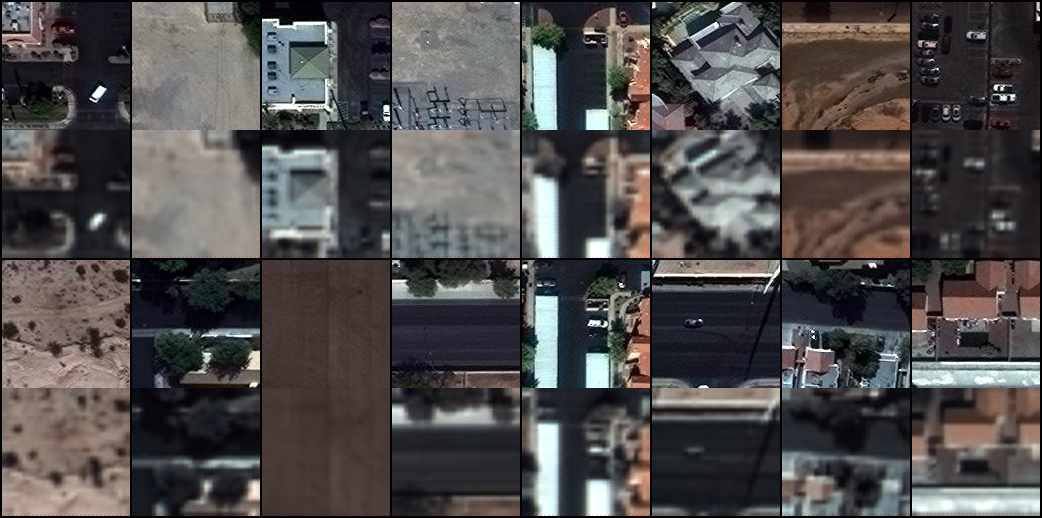

In [ ]:
PIL.Image.open(dir_esrgan/'samples/5/SR_0.png')

The trained parameters are saved at `ESRGAN0-pytorch/checkpoints`.

In [ ]:
(dir_esrgan/'checkpoints').ls()[-4:]

[PosixPath('/content/ESRGAN-pytorch/checkpoints/discriminator_4.pth'),
 PosixPath('/content/ESRGAN-pytorch/checkpoints/discriminator_1.pth'),
 PosixPath('/content/ESRGAN-pytorch/checkpoints/discriminator_7.pth'),
 PosixPath('/content/ESRGAN-pytorch/checkpoints/discriminator_6.pth')]

## Test trained model

How do we take the model we've just trained and apply it to some image?

In [ ]:
from model.ESRGAN import ESRGAN
from torchvision.utils import save_image
import torchvision.transforms.functional as TF

In [ ]:
# loaded_generator = torch.load(dir_esrgan/'parameters'/'gan.pth')
loaded_generator = torch.load(dir_esrgan/'checkpoints'/'generator_9.pth')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

We can use any image, but let's use one of the low-resolution training examples, like this one:

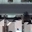

In [ ]:
idxs = 9

PIL.Image.open(dir_lr.ls()[idx]).convert('RGB')

Pass it through our trained model.

In [ ]:
%%time

with torch.no_grad():
    net = ESRGAN(3, 3, scale_factor=4)
    net.load_state_dict(loaded_generator)
    net = net.to(device).eval()

    img = PIL.Image.open(dir_lr.ls()[idx]).convert('RGB')
    img = TF.to_tensor(img).to(device).unsqueeze(dim=0)

    img = net(img)
    save_image(img, 'test_sr.png')

CPU times: user 605 ms, sys: 77.6 ms, total: 683 ms
Wall time: 685 ms


to get this:

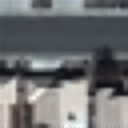

In [ ]:
PIL.Image.open('test_sr.png')

Note that it's, as expected, 4 times larger than the input.  It doesn't look good, no where near its high-resolution counterpart, but the model was only trained from scratch with 500 examples for just 10 epochs.

## TODOs
1. How to load pre-trained parameters and train from there?
2. Will things break if the default `scale_factor` is changed?
3. What training results in the *psnr.pth* and *gan.pth* sets of the parameters?

## Reference
- [`ESRGAN-pytorch` by wonbeomjang](https://github.com/wonbeomjang/ESRGAN-pytorch)